# P12 Testing Scripts

In [17]:
# ❗️set-up

%load_ext autoreload
%autoreload 2

import pickle
import numpy as np
import xgboost as xgb
from src.utils import *
from matplotlib import pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1 Data Preparation

### 1.1 Preprocessing

Dataset splits: the same splits throughout the whole experiment
Each split will be loaded into 2 numpy arrays:
- x: (N, L, 3C), where N = # of episodes, L = max sequence length across all splits, C = # of features and 3C for var-mask-interval
- y: (N, ), labels

In [2]:
# ❗️load train, valid, test datasets

split_pickle_paths = {'train': './data/p12/p12_clean_train.pkl',
                      'valid': './data/p12/p12_clean_valid.pkl',
                      'test': './data/p12/p12_clean_test.pkl'}
max_max_seq_len = 0
for filename in split_pickle_paths.values():
    metadata = load_metadata_from_pickle(filename)
    if metadata['max_seq_len'] > max_max_seq_len:
        max_max_seq_len = metadata['max_seq_len']
print(f"max max sequence length = {max_max_seq_len}")

def load_pickle_as_arrays(filename, max_seq_len=None, concat_mask_and_interval=True):
    with open(filename, 'rb') as f:
        dataset = pickle.load(f)
    data_list = dataset['data']
    metadata = dataset['meta']
    if max_seq_len is None:
        max_seq_len = metadata['max_seq_len']
    ds_size = metadata['size']
    num_vars = metadata['num_vars']
    print(f"----------Loading dataset: {metadata['name']}----------")
    print(f"split = {metadata['split']}")
    print(f'dataset size = {ds_size}')
    print(f"max sequence length in dataset = {metadata['max_seq_len']}")
    print(f"this dataset will be padded to a length of = {max_seq_len}")
    print(f'num variables = {num_vars}')
    x = []
    t = [] # for imputation convenience only, x should already contain time info by concatenating intervals with variables and masks
    y = []
    for i, data_dict in enumerate(data_list):
        var = data_dict['var'].astype(np.float32)
        time = data_dict['time'].astype(np.float32)
        interval = data_dict['interval'].astype(np.float32)
        mask = data_dict['mask'].astype(np.float32)
        label = int(data_dict['label']['In-hospital_death']) # label is defined here
        seq_len = var.shape[0]

        # >>> 1. Pad input to same length so they can later be stacked as an array >>>
        var_padded = np.pad(var, ((max_seq_len-seq_len, 0), (0, 0)), mode='constant', constant_values=np.nan) # pad nan to the beginning of var
        interval_padded = np.pad(interval, ((max_seq_len-seq_len, 0), (0, 0)), mode='constant', constant_values=np.nan) # pad nan to the beginning of interval
        mask_padded = np.pad(mask, ((max_seq_len-seq_len, 0), (0, 0)), mode='constant', constant_values=0) # pad 0 to the beginning of mask
        time_padded = np.pad(time, ((max_seq_len-seq_len, 0)), mode='constant', constant_values=np.nan) # pad nan to the beginning of timestamps
        # <<< 1. Pad input to same length so they can later be stacked as an array <<<

        # >>> 2. Concatenated input (GRU-Simple in GRU-D) >>>
        var_concat = np.hstack((var_padded, mask_padded, interval_padded))
        # <<< 2. Concatenated input (GRU-Simple in GRU-D) <<<

        if concat_mask_and_interval:
            x.append(var_concat)
        else:
            x.append(var_padded)
        y.append(label)
        t.append(time_padded)
    x = np.array(x, dtype=np.float32) # (N, T, C)
    print(f"feature array shape = {x.shape}")
    y = np.array(y, dtype=np.int32) # (N, )
    print(f"label array shape = {y.shape}")
    t = np.array(t, dtype=np.float32) # (N, T)
    print(f"timestamp array shape = {t.shape}")
    return x, y, t

x_train, y_train, t_train = load_pickle_as_arrays(split_pickle_paths['train'], max_seq_len=max_max_seq_len)
x_valid, y_valid, t_valid = load_pickle_as_arrays(split_pickle_paths['valid'], max_seq_len=max_max_seq_len)
x_test, y_test, t_test = load_pickle_as_arrays(split_pickle_paths['test'], max_seq_len=max_max_seq_len)
print(x_train[0])
print(y_train[0])
print(t_train[0])


max max sequence length = 215
----------Loading dataset: p12----------
split = train
dataset size = 9590
max sequence length in dataset = 215
this dataset will be padded to a length of = 215
num variables = 37
feature array shape = (9590, 215, 111)
label array shape = (9590,)
timestamp array shape = (9590, 215)
----------Loading dataset: p12----------
split = valid
dataset size = 1199
max sequence length in dataset = 171
this dataset will be padded to a length of = 215
num variables = 37
feature array shape = (1199, 215, 111)
label array shape = (1199,)
timestamp array shape = (1199, 215)
----------Loading dataset: p12----------
split = test
dataset size = 1199
max sequence length in dataset = 203
this dataset will be padded to a length of = 215
num variables = 37
feature array shape = (1199, 215, 111)
label array shape = (1199,)
timestamp array shape = (1199, 215)
[[      nan       nan       nan ...       nan       nan       nan]
 [      nan       nan       nan ...       nan       nan

Drop a feature iff:
- std is 0 on train set (only one value is observed)
- missing rate is higher than a threshold (TODO)

Based on these criteria, create a keep mask `feature_mask_keep` and the # of selected features `n_features_selected`.

Use the mask to slice x and train stats.

In [175]:
# ❗️select raw features, drop a feature if missing value is too high or has a 0 std in train set

metadata_train = load_metadata_from_pickle(split_pickle_paths['train'])
mean_vec_train = metadata_train['mean']
std_vec_train = metadata_train['std']
var_names = metadata_train['var_names']
missing_rates = metadata_train['missing_rates']

feature_mask_keep = ~(std_vec_train == 0) # valid features are True
print(feature_mask_keep)

# TODO: consider filtering out extremely missing features here (by modifying `feature_mask``)

def select_features(x, feature_keep_mask, copy=True):
    input_keep_mask = np.tile(feature_keep_mask, 3)
    if copy:
        return x[:,:,input_keep_mask].copy()
    else:
        return x[:,:,input_keep_mask]

mean_vec_train_selected = mean_vec_train[feature_mask_keep]
std_vec_train_selected = std_vec_train[feature_mask_keep]

x_train_selected = select_features(x_train, feature_mask_keep)
x_valid_selected = select_features(x_valid, feature_mask_keep)
x_test_selected = select_features(x_test, feature_mask_keep)

var_names_selected = list(np.array(var_names, dtype=str)[feature_mask_keep])
n_features_selected = len(var_names_selected)

missing_rates_selected = missing_rates[feature_mask_keep]

print("These features are kept:")
print(var_names_selected)
print("Missing rates are:")
print(missing_rates_selected) 

print("These features are dropped:")
print(np.array(var_names, dtype=str)[~feature_mask_keep])

print(x_train_selected.shape)

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True False  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True]
These features are kept:
['Albumin', 'ALP', 'ALT', 'AST', 'Bilirubin', 'BUN', 'Cholesterol', 'Creatinine', 'DiasABP', 'FiO2', 'GCS', 'Glucose', 'HCO3', 'HCT', 'HR', 'K', 'Lactate', 'Mg', 'MAP', 'Na', 'NIDiasABP', 'NIMAP', 'NISysABP', 'PaCO2', 'PaO2', 'pH', 'Platelets', 'RespRate', 'SaO2', 'SysABP', 'Temp', 'TroponinI', 'TroponinT', 'Urine', 'WBC', 'Weight']
Missing rates are:
[0.99199235 0.9894654  0.98916686 0.9891599  0.98903847 0.95349866
 0.9988726  0.95328516 0.50995344 0.89436144 0.7922028  0.95611346
 0.95442796 0.9386205  0.23410852 0.95116293 0.97288924 0.95445025
 0.51553744 0.95421165 0.67054886 0.67521757 0.670221   0.92334753
 0.9235359  0.919876   0.9523545  0.8156844  0.97340965 0.5097595
 0.7127471  0.9986968  0.9930611  0.54665834 0.9564665  0.56

Normalize input variables.

All splits are normalized with stats on the train set.

Note that this may not be necessary, because there is no simple way to normalize the time interval part in input data. (positional encoding maybe?)

In [4]:
# ❗️normalize input feature variables

def normalize_variables(x: np.ndarray, mean: np.ndarray, std: np.ndarray, inplace=False):
    assert mean.shape == std.shape
    feature_dim = mean.shape[0]
    assert feature_dim <= x.shape[2]
    var = x[:,:,:feature_dim] # take a slice (reference) of the variable part in input x
    if inplace:
        x[:, :, :feature_dim] = (var - mean) / std
    else:
        x_normalized = x.copy()
        x_normalized[:, :, :feature_dim] = (var - mean) / std
        return x_normalized


x_train_normalized = normalize_variables(x_train_selected, mean_vec_train_selected, std_vec_train_selected)
x_valid_normalized = normalize_variables(x_valid_selected, mean_vec_train_selected, std_vec_train_selected) # normalize valid with train stats
x_test_normalized = normalize_variables(x_test_selected, mean_vec_train_selected, std_vec_train_selected) # normalize test with train stats

# see how temperature gets normalized
print(x_train_selected[0,:,30])
print(x_train_normalized[0,:,30])

[ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan 39.8
  nan  nan 40.2  nan  nan  nan 40.1  nan 40.1  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan 39.1  nan 38.6  nan  nan 38.3  nan  nan 37.7
  nan  nan  nan 37.5  nan  nan  nan  nan  nan  nan 38.1  nan 38.2  nan
  nan 37.7  nan  nan 37.8  nan  nan  nan 38.   nan  nan 37.4  nan  nan
  nan 

In [5]:
# ❗️slice x-m-d
x_train_varonly = x_train_normalized[:,:,:n_features_selected]
x_train_maskonly = x_train_normalized[:,:,n_features_selected:2*n_features_selected]
x_train_intervalonly = x_train_normalized[:,:,-n_features_selected:]
x_valid_varonly = x_valid_normalized[:,:,:n_features_selected]
x_valid_maskonly = x_valid_normalized[:,:,n_features_selected:2*n_features_selected]
x_valid_intervalonly = x_valid_normalized[:,:,-n_features_selected:]

### 1.2 Utility functions

first episode before normalization:


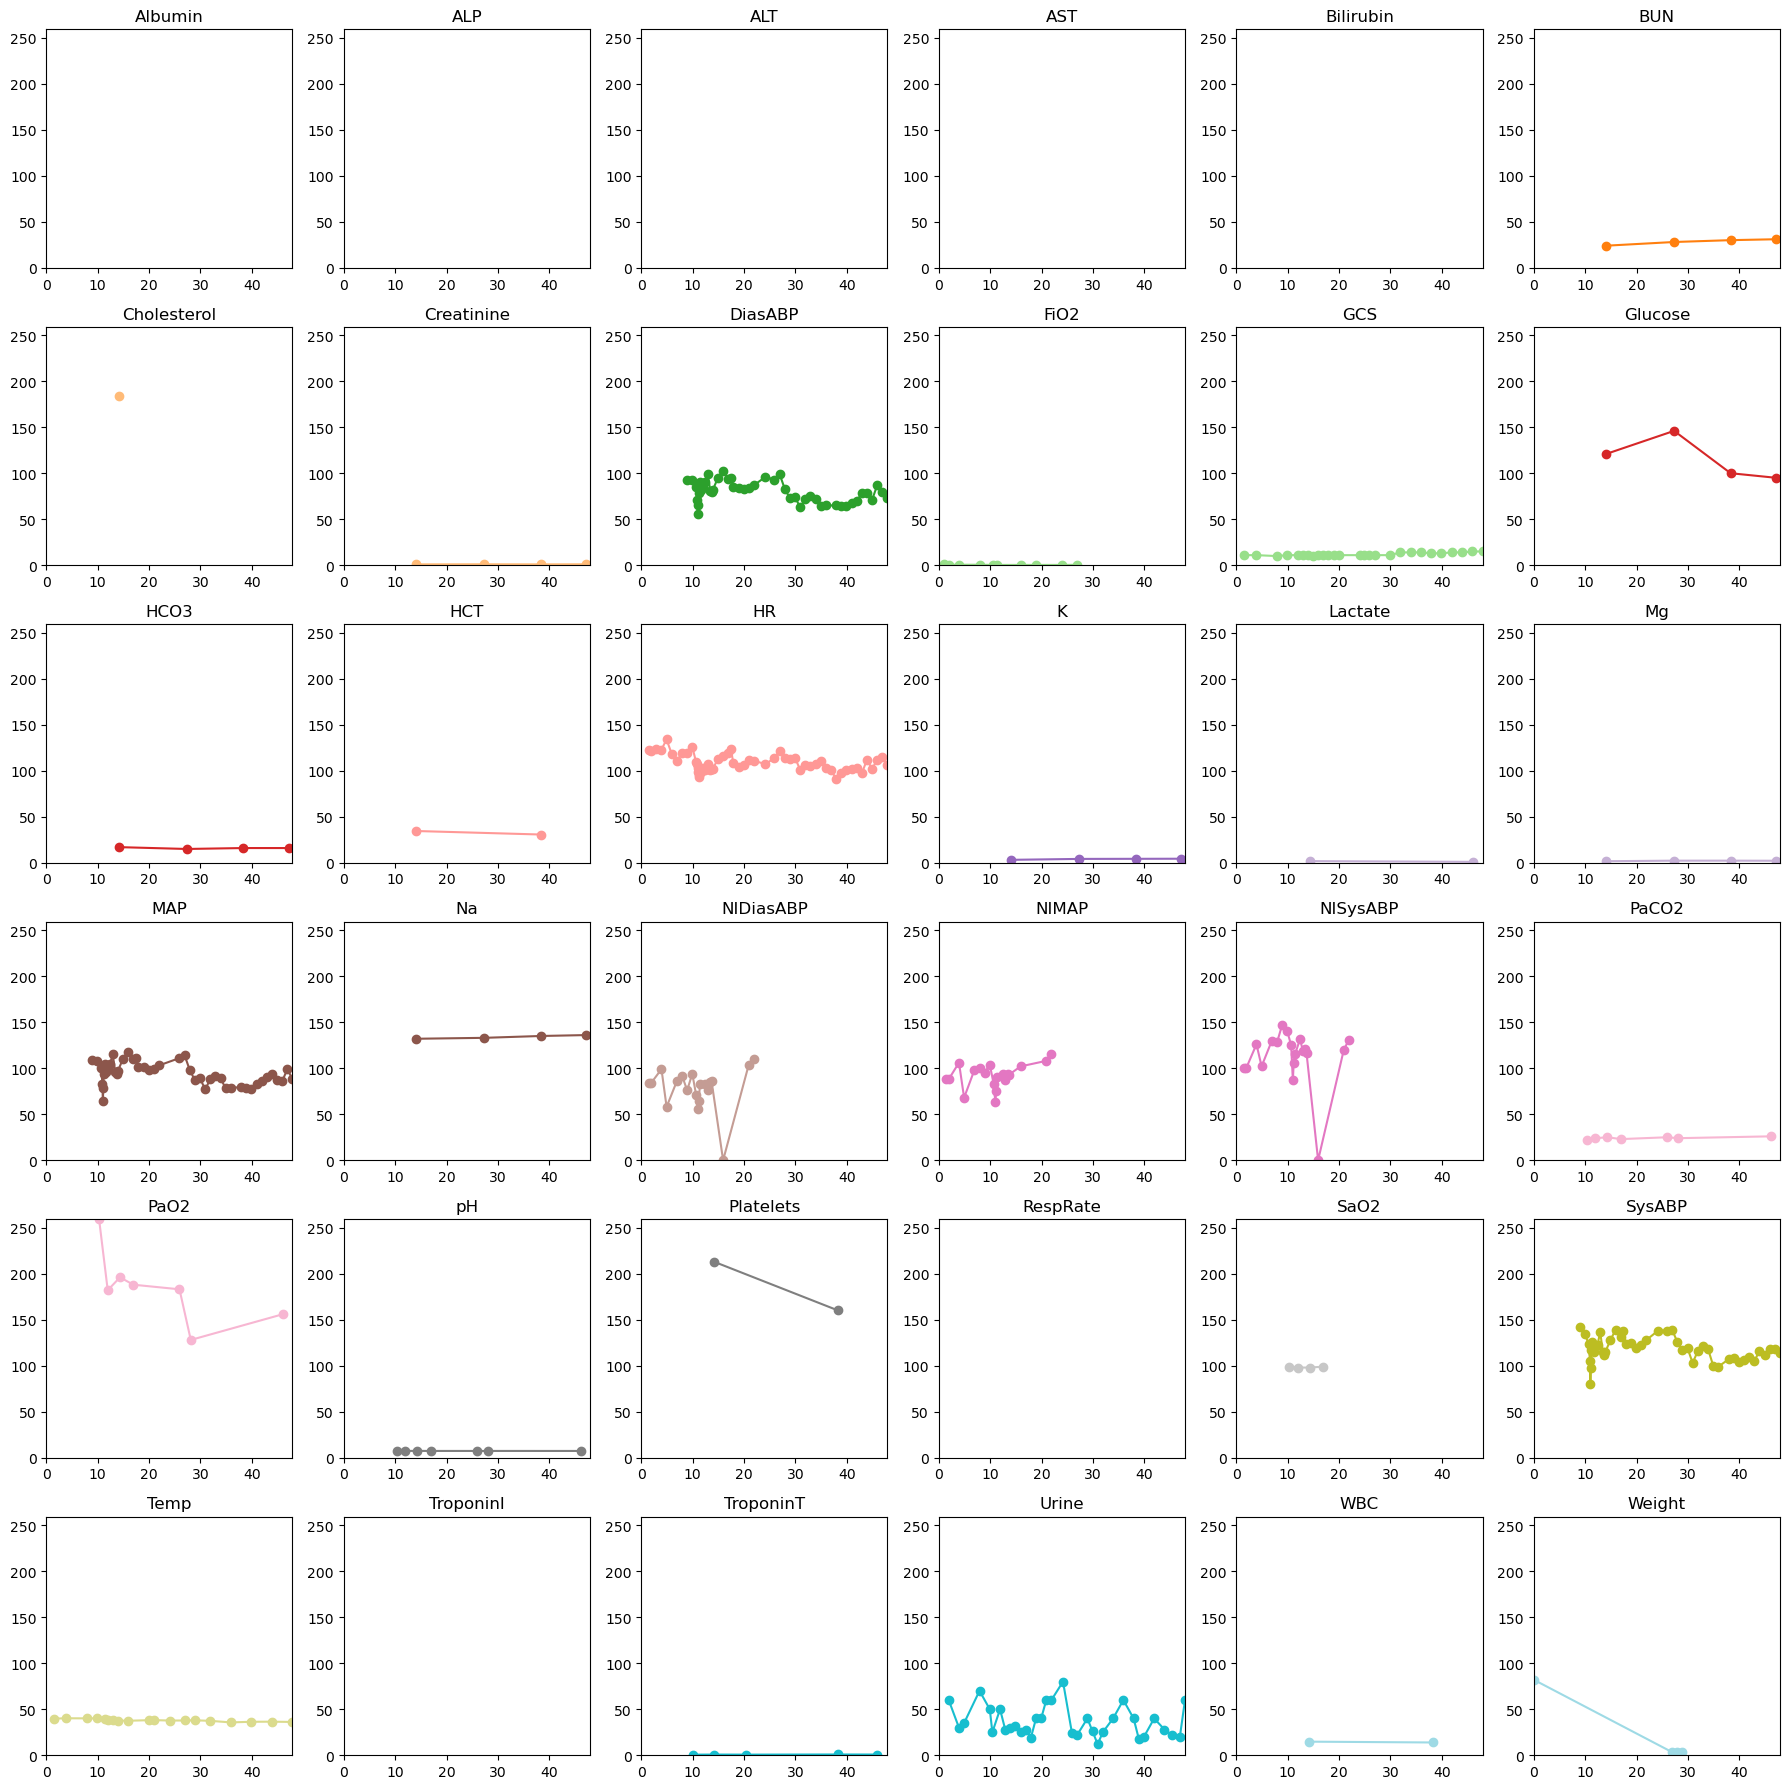

first episode after normalization:


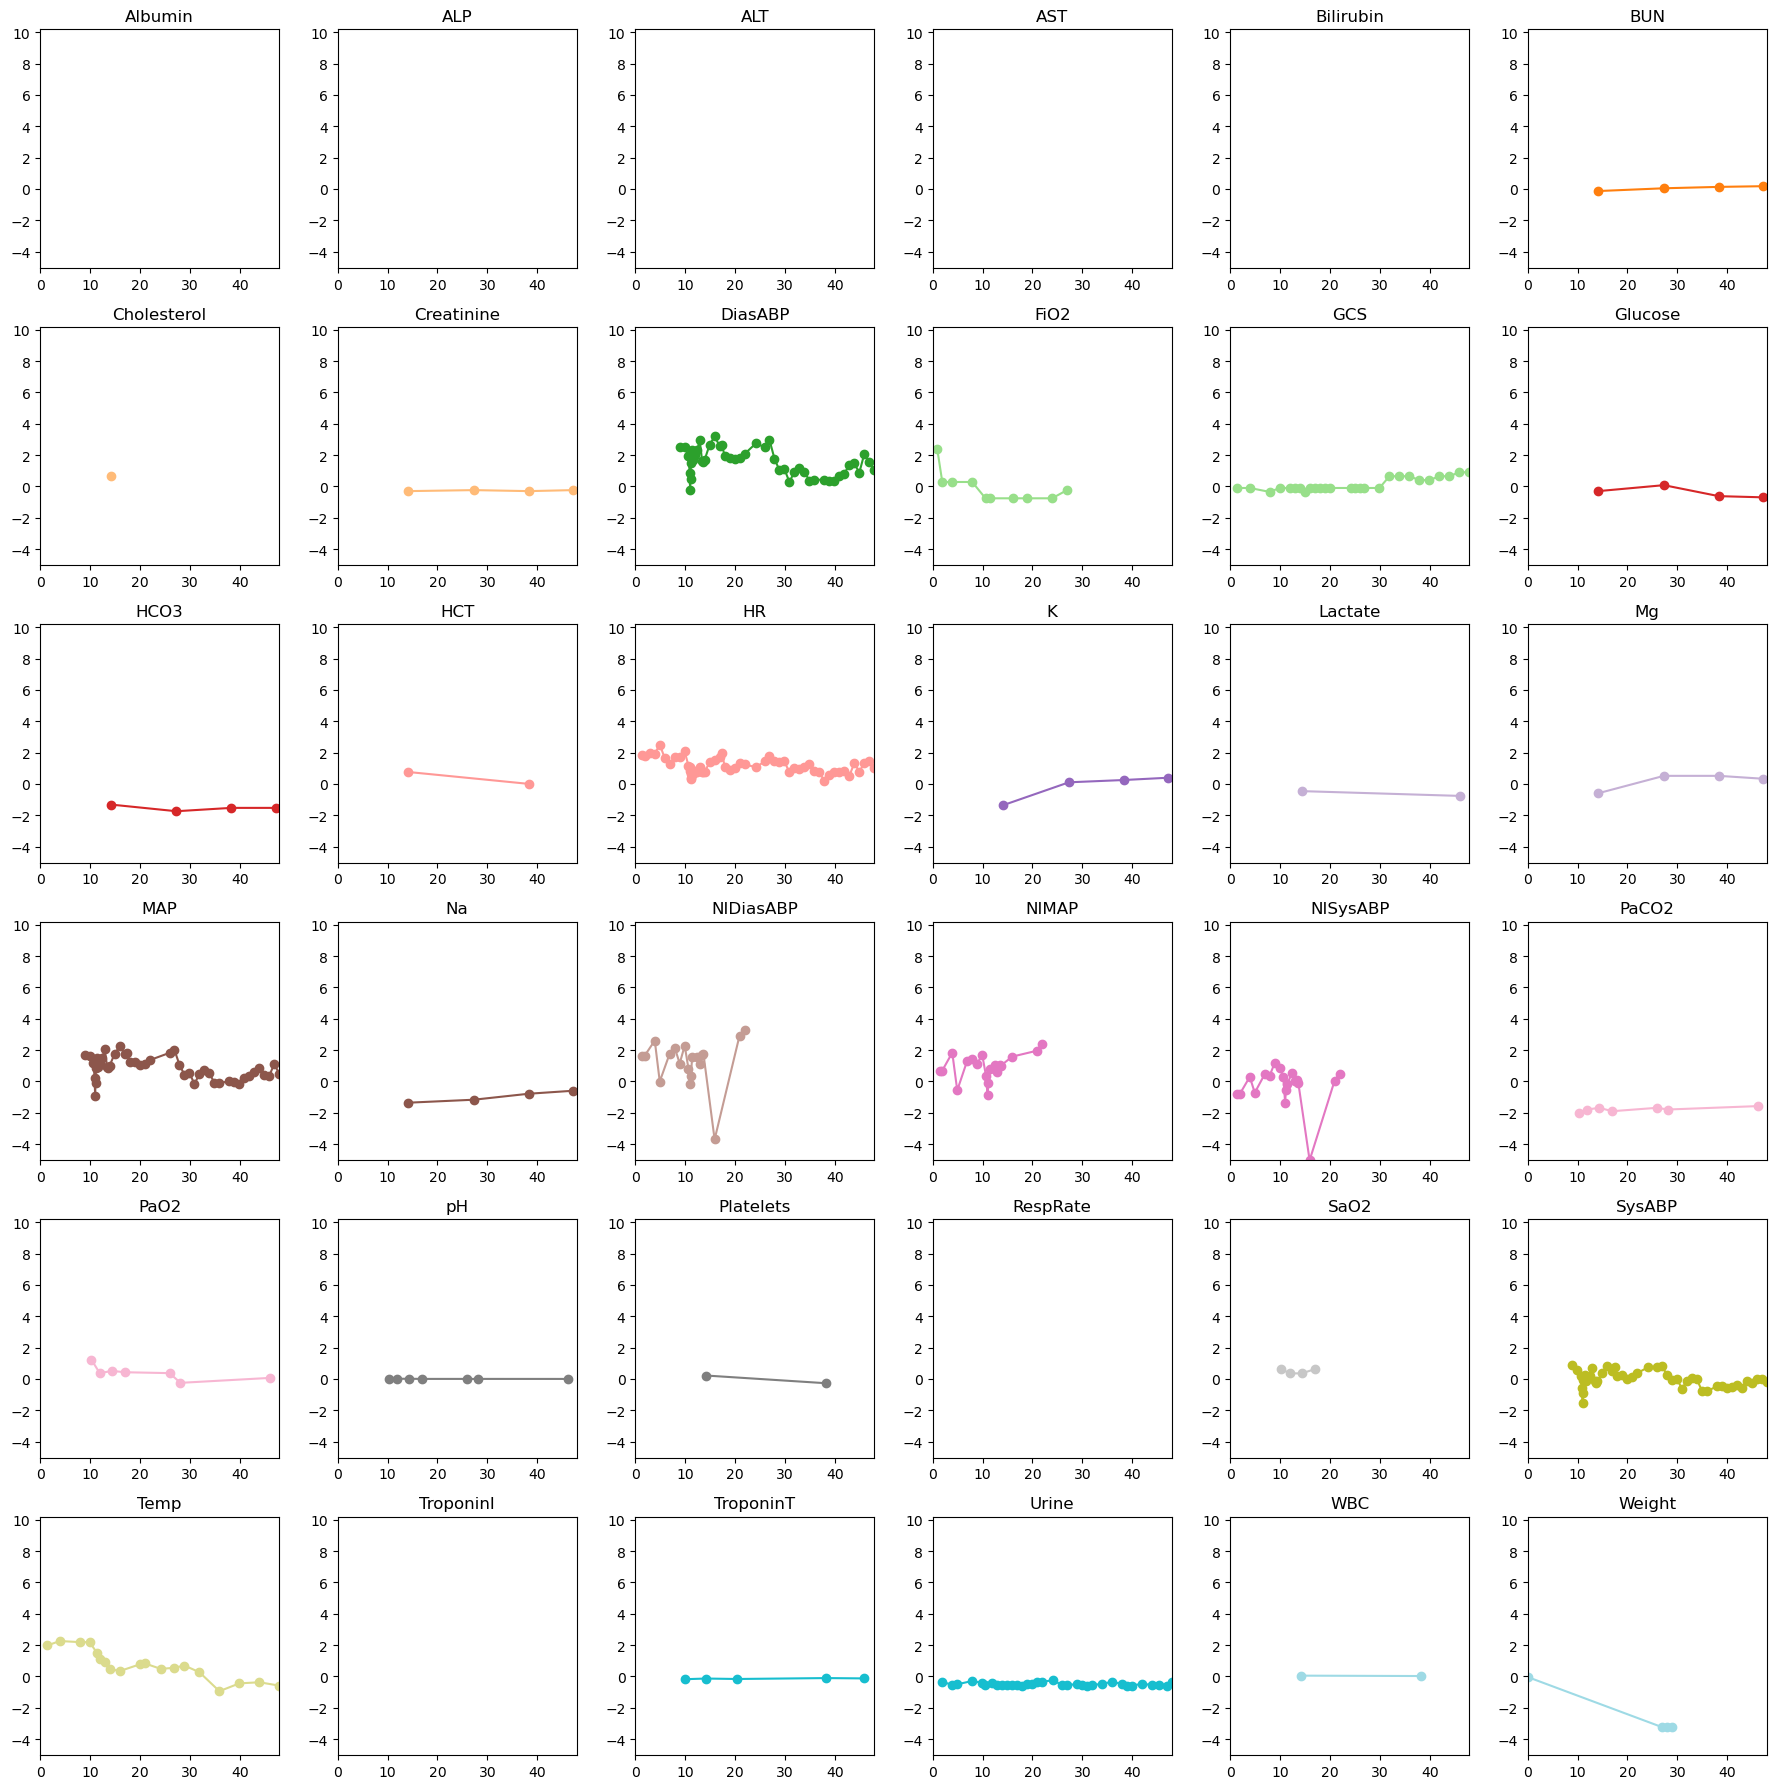

In [6]:
# ❗️plot function

def plot_multivariate_ts(x, t, var_names):
    L, C = x.shape  # L is the sequence length, C is the number of features
    max_channels = min(C, 36)  # Limit the number of channels to 36
    
    # Define a fixed set of colors
    colors = plt.cm.tab20(np.linspace(0, 1, 36))  # Use tab20 colormap for distinct colors
    
    # Create a 6x6 grid for subplots
    fig, axes = plt.subplots(6, 6, figsize=(18, 18))  # 6x6 grid of subplots
    axes = axes.flatten()  # Flatten to iterate easily over axes

    for i in range(max_channels):
        # Get valid (non-NaN) indices for the i-th feature
        valid_idx = ~np.isnan(x[:, i])
        valid_times = t[valid_idx]
        valid_values = x[valid_idx, i]

        # Plot the dots and connect them with lines using the fixed color
        axes[i].plot(valid_times, valid_values, marker='o', linestyle='-', color=colors[i])
        
        # Set title using var_names
        axes[i].set_title(f'{var_names[i]}')
        axes[i].set_xlim([np.nanmin(t), np.nanmax(t)])  # Set x-axis to time range
        axes[i].set_ylim([np.nanmin(x), np.nanmax(x)])  # Set y-axis to feature value range

    # Turn off unused subplots if there are fewer than 36 channels
    for j in range(max_channels, 36):
        fig.delaxes(axes[j])  # Remove unused subplots

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

print("first episode before normalization:")
plot_multivariate_ts(x_train_selected[0], t_train[0], var_names_selected)

print("first episode after normalization:")
plot_multivariate_ts(x_train_normalized[0], t_train[0], var_names_selected)

In [43]:
# ❗️fit and test xgb
from sklearn.metrics import roc_auc_score

def quick_fit_and_test_xgb_classifier(x_train, y_train, x_test, y_test):
    # fit classifier
    classifier = xgb.XGBClassifier(
        n_estimators=100,    # Number of gradient boosted trees. Equivalent to number of boosting rounds.
        max_depth=3,         # Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit.
        learning_rate=0.1,   # Step size shrinkage used in update to prevents overfitting. After each boosting step, we can directly get the weights of new features.
        eval_metric='logloss' # Evaluation metric for validation data during training
    )
    classifier.fit(x_train, y_train)

    # evaluate model
    y_test_probs = classifier.predict_proba(x_test)[:, 1] # probabilities for the positive class
    return roc_auc_score(y_test, y_test_probs)

## 2 Preliminaries
### 2.1 XGBoost on raw data

In [11]:
# on variables alone (with missing values as NaNs)
x_train_varonly_flat = x_train_varonly.reshape(x_train_varonly.shape[0], -1)
print(x_train_varonly_flat.shape)

x_valid_varonly_flat = x_valid_varonly.reshape(x_valid_varonly.shape[0], -1)

auroc = quick_fit_and_test_xgb_classifier(x_train_varonly_flat, y_train, x_valid_varonly_flat, y_valid)
print(f"XGBoost classifier on raw variables alone, AUROC: {auroc:.4f}")


(9590, 7740)
XGBoost classifier on raw variables alone, AUROC: 0.8065


In [ ]:
# on concatenated input (var-mask-interval)

x_train_flat = x_train_normalized.reshape(x_train_varonly.shape[0], -1)
print(x_train_flat.shape)

x_valid_flat = x_valid_normalized.reshape(x_valid_varonly.shape[0], -1)

auroc = quick_fit_and_test_xgb_classifier(x_train_flat, y_train, x_valid_flat, y_valid)
print(f"XGBoost classifier on concatenated raw input (var-mask-interval), AUROC: {auroc:.4f}")

In [ ]:
# on other combinations of 2 input modalities (var-mask, var-interval, mask-interval)

# >>> var-mask >>>
x_train_varmask = np.concatenate([x_train_varonly, x_train_maskonly], axis=-1)
x_train_varmask_flat = x_train_varmask.reshape(x_train_varmask.shape[0], -1)
print(x_train_varmask_flat.shape)

x_valid_varmask = np.concatenate([x_valid_varonly, x_valid_maskonly], axis=-1)
x_valid_varmask_flat = x_valid_varmask.reshape(x_valid_varmask.shape[0], -1)

auroc = quick_fit_and_test_xgb_classifier(x_train_varmask_flat, y_train, x_valid_varmask_flat, y_valid)
print(f"XGBoost classifier on raw var-mask, AUROC: {auroc:.4f}")
# <<< var-mask <<<

# >>> var-interval >>>
x_train_varinterval = np.concatenate([x_train_varonly, x_train_intervalonly], axis=-1)
x_train_varinterval_flat = x_train_varinterval.reshape(x_train_varinterval.shape[0], -1)
print(x_train_varinterval_flat.shape)

x_valid_varinterval = np.concatenate([x_valid_varonly, x_valid_intervalonly], axis=-1)
x_valid_varinterval_flat = x_valid_varinterval.reshape(x_valid_varinterval.shape[0], -1)

auroc = quick_fit_and_test_xgb_classifier(x_train_varinterval_flat, y_train, x_valid_varinterval_flat, y_valid)
print(f"XGBoost classifier on raw var-interval, AUROC: {auroc:.4f}")
# <<< var-interval <<<

# >>> mask-interval >>>
x_train_maskinterval = np.concatenate([x_train_maskonly, x_train_intervalonly], axis=-1)
x_train_maskinterval_flat = x_train_maskinterval.reshape(x_train_maskinterval.shape[0], -1)
print(x_train_maskinterval_flat.shape)

x_valid_maskinterval = np.concatenate([x_valid_maskonly, x_valid_intervalonly], axis=-1)
x_valid_maskinterval_flat = x_valid_maskinterval.reshape(x_valid_maskinterval.shape[0], -1)

auroc = quick_fit_and_test_xgb_classifier(x_train_maskinterval_flat, y_train, x_valid_maskinterval_flat, y_valid)
print(f"XGBoost classifier on raw mask-interval, AUROC: {auroc:.4f}")
# <<< mask-interval <<<

### 2.2 Imputation
Impute the variables using 3 imputers:
- Zero-imputer: replace all nan's with 0's (same as a mean-imputer if input is normalized)
- Forward-imputer: replace leading nan's (where t is nan) with 0's, then use forward-filling
- Linear-imputer: replace leading nan's (where t is nan) with 0's, then use linear interpolation

In [12]:
# ❗️define imputers 

def zero_imputer(x, inplace=False): # for normalized x, this is the same as a mean-imputer
    if not inplace:
        x = x.copy()
    np.nan_to_num(x, copy=False, nan=0)
    return x

def forward_imputer(x, t, inplace=False):
    if not inplace:
        x = x.copy()
    
    # Iterate over episodes
    for i in range(x.shape[0]):
        # Find the first non-NaN index in time stamps
        valid_idx = np.where(~np.isnan(t[i]))[0]
        
        if len(valid_idx) > 0:
            first_valid_idx = valid_idx[0]
            
            # Fill the NaNs before the first valid timestamp with 0 (in-place)
            x[i, :first_valid_idx, :] = 0
            
            # Forward fill after the first valid time stamp (in-place)
            for j in range(first_valid_idx, x.shape[1]):
                nan_mask = np.isnan(x[i, j, :])
                if j == 0: # If first valid time stamp is at 0, replace all nan's with 0's
                    x[i, j, nan_mask] = 0
                else:
                    x[i, j, nan_mask] = x[i, j - 1, nan_mask]
        else:
            # If no valid time stamps, fill entire episode with 0 (in-place)
            x[i, :, :] = 0

    return x


def linear_imputer(x, t, inplace=False):
    if not inplace:
        x = x.copy()

    # Iterate over episodes (N)
    for i in range(x.shape[0]):
        # Iterate over features (C)
        for c in range(x.shape[2]):
            # Find the indices of valid (non-NaN) values in x for the current feature c
            valid_idx = np.where(~np.isnan(x[i, :, c]))[0]

            if len(valid_idx) > 0:
                # Get the first valid index for this feature
                first_valid_idx = valid_idx[0]

                # Fill the NaNs before the first valid timestamp with 0 (in-place)
                x[i, :first_valid_idx, c] = 0

                # Perform interpolation if there are valid values
                valid_t = t[i, valid_idx]  # Corresponding valid timestamps
                valid_x = x[i, valid_idx, c]  # Valid feature values for feature c

                # Interpolate missing values for this feature
                interp_x = np.interp(t[i, first_valid_idx:], valid_t, valid_x)

                # Fill NaNs in feature c with interpolated values
                nan_mask = np.isnan(x[i, first_valid_idx:, c])
                x[i, first_valid_idx:, c][nan_mask] = interp_x[nan_mask]

            else:
                # If no valid values for the feature, fill the entire feature with 0
                x[i, :, c] = 0

    return x

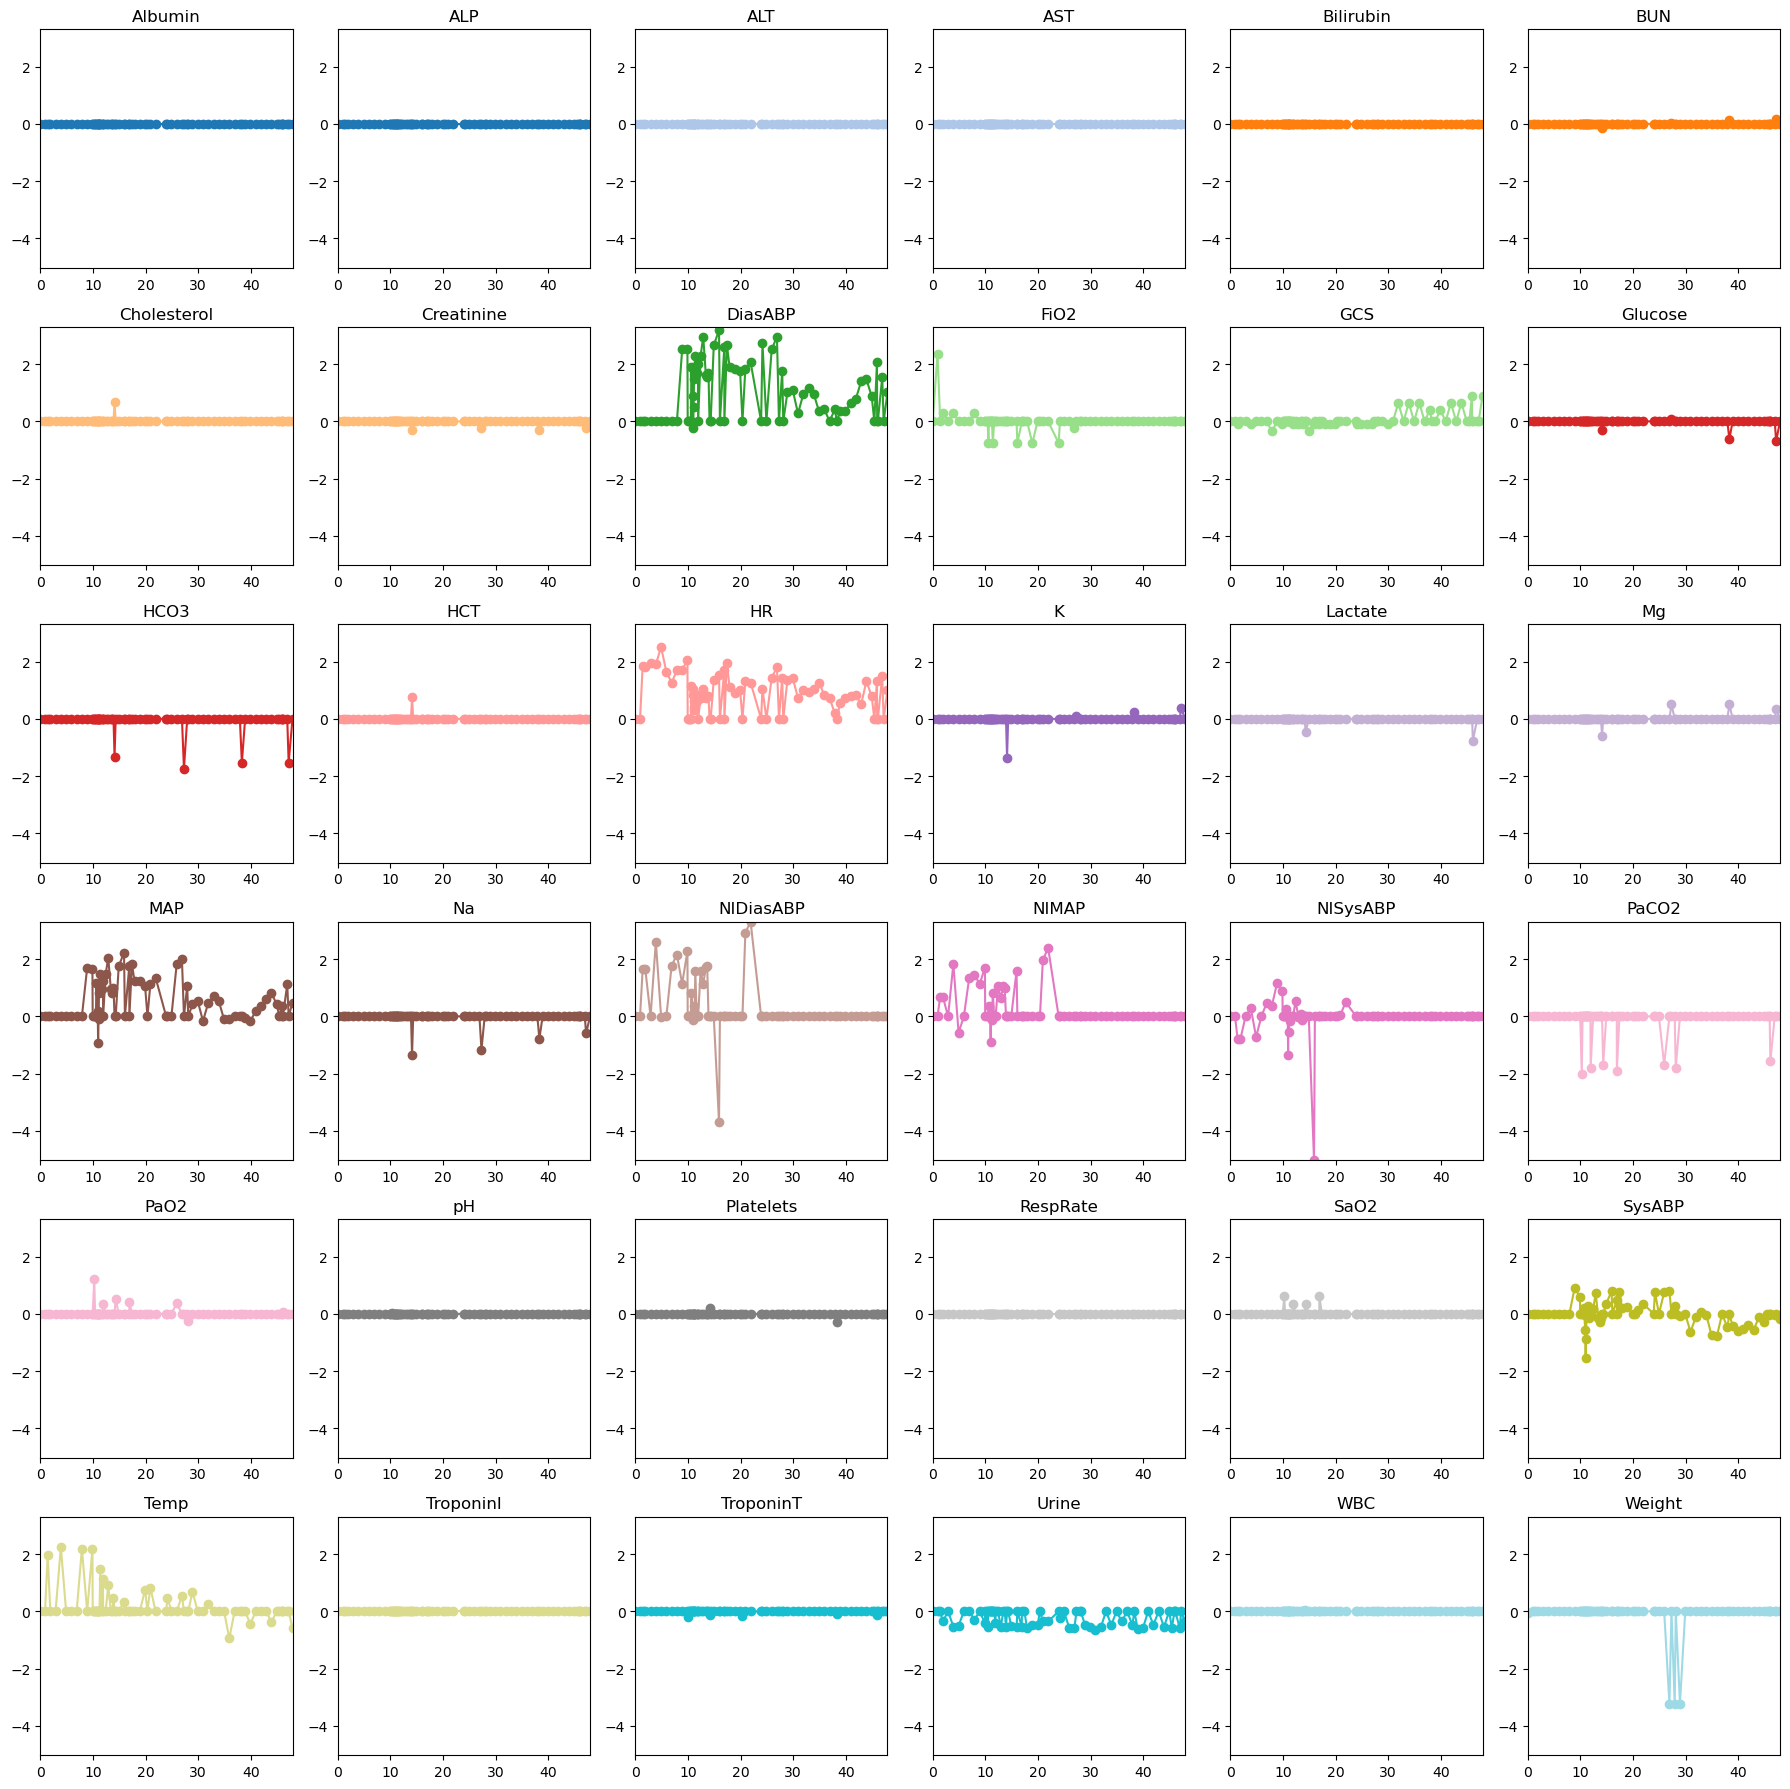

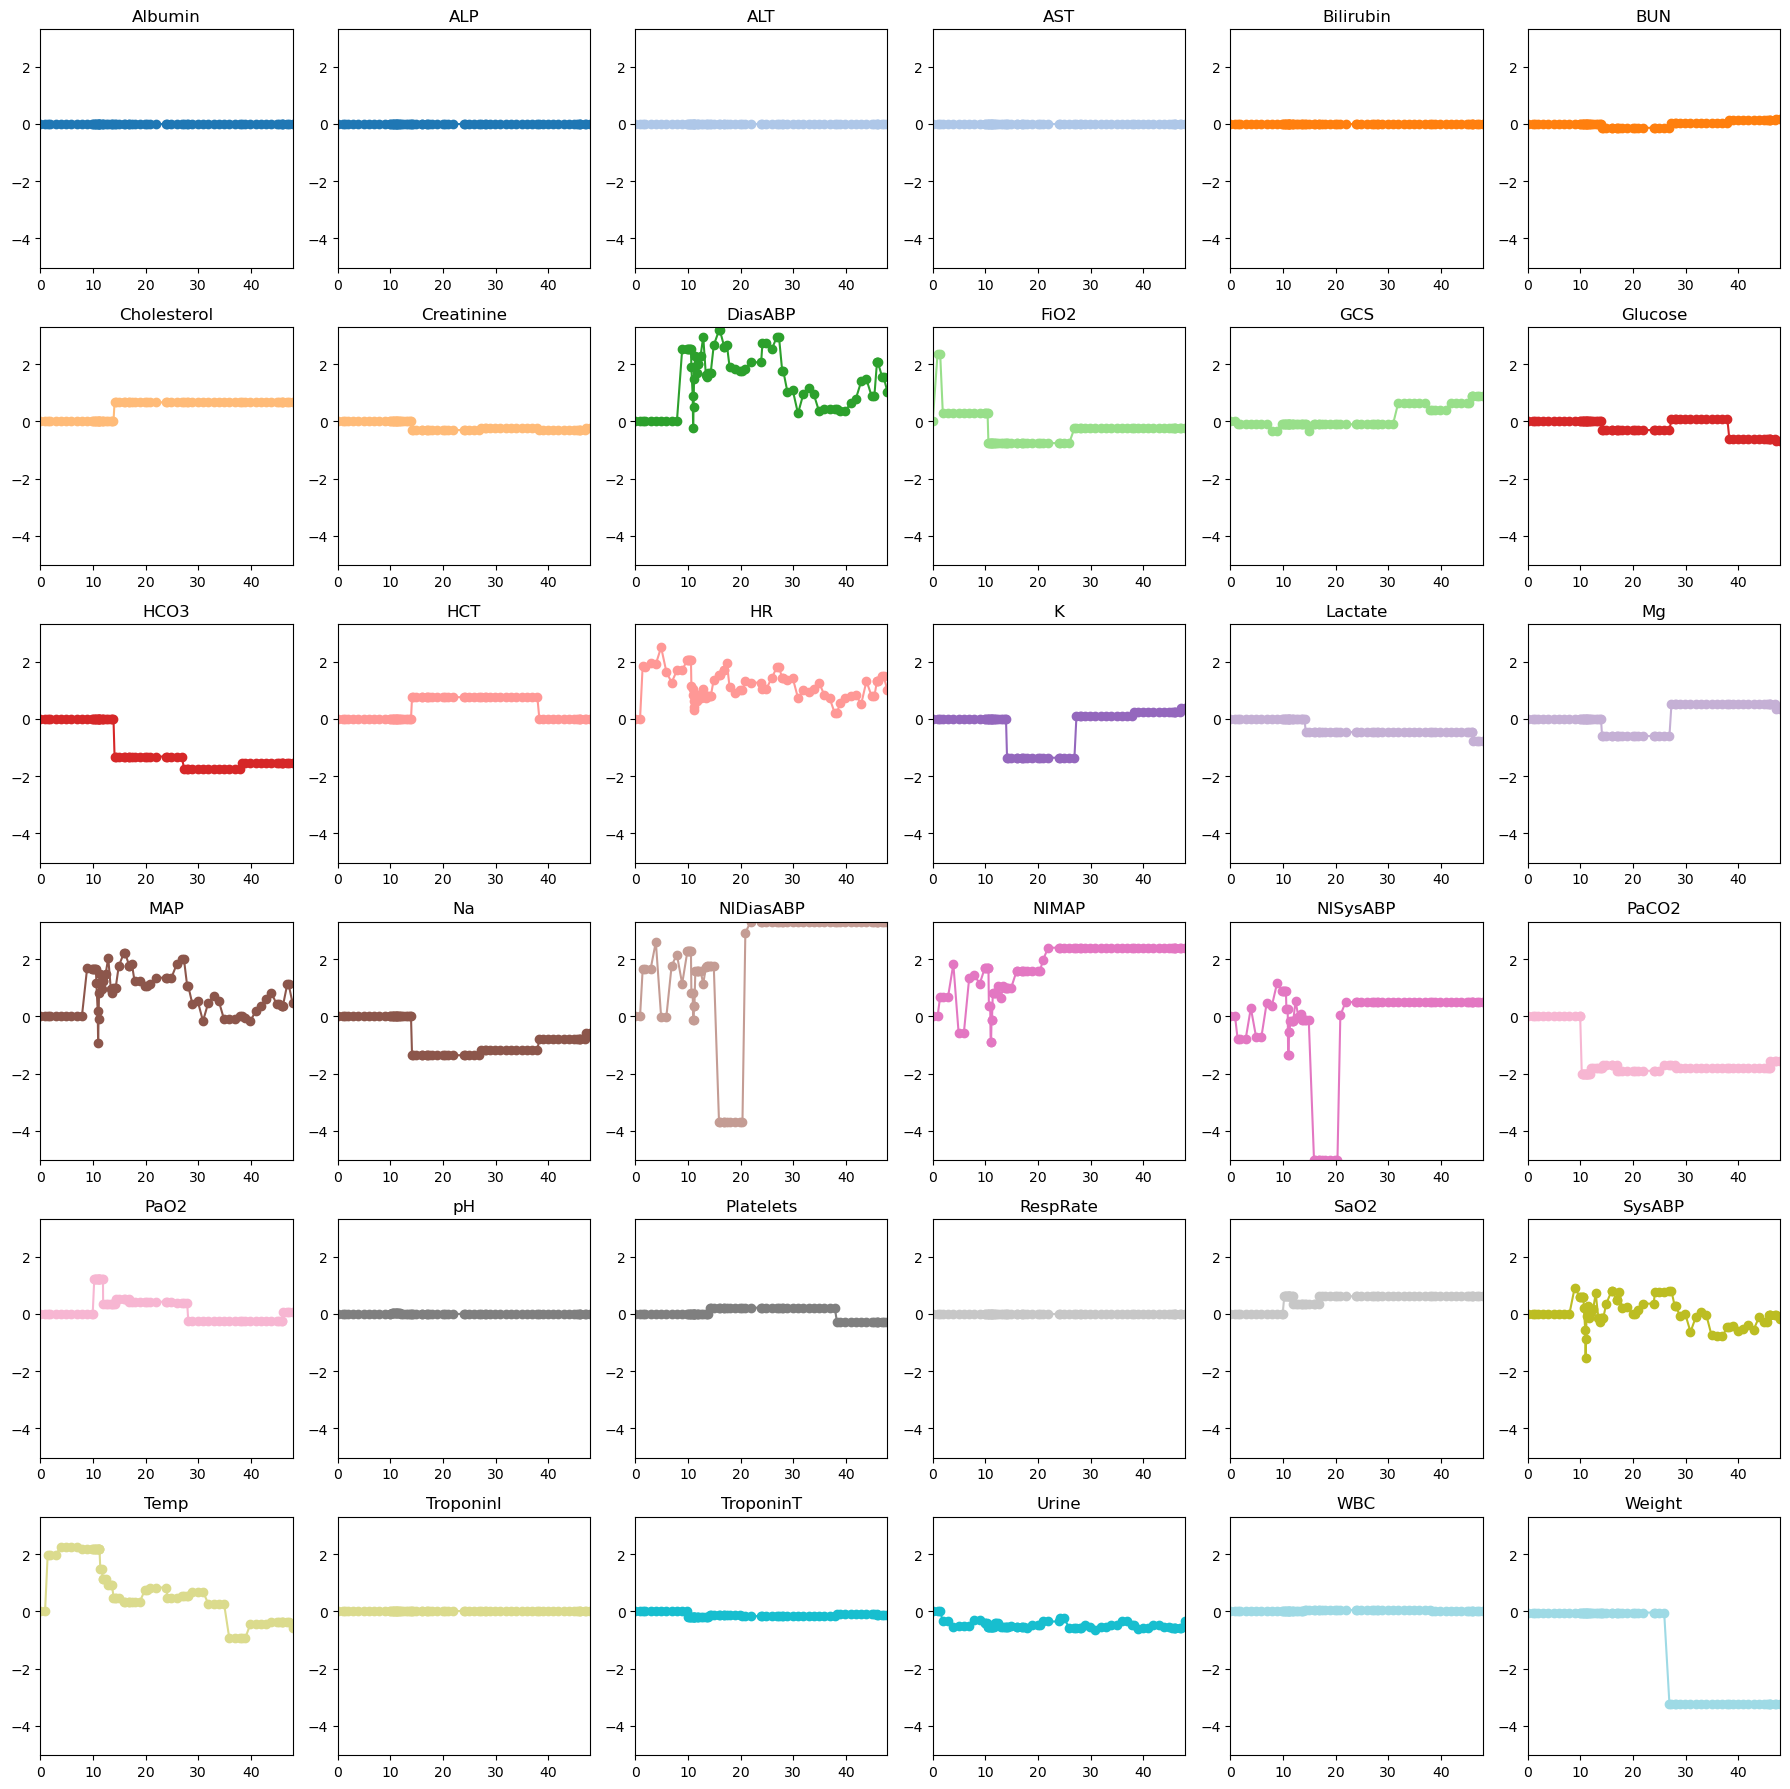

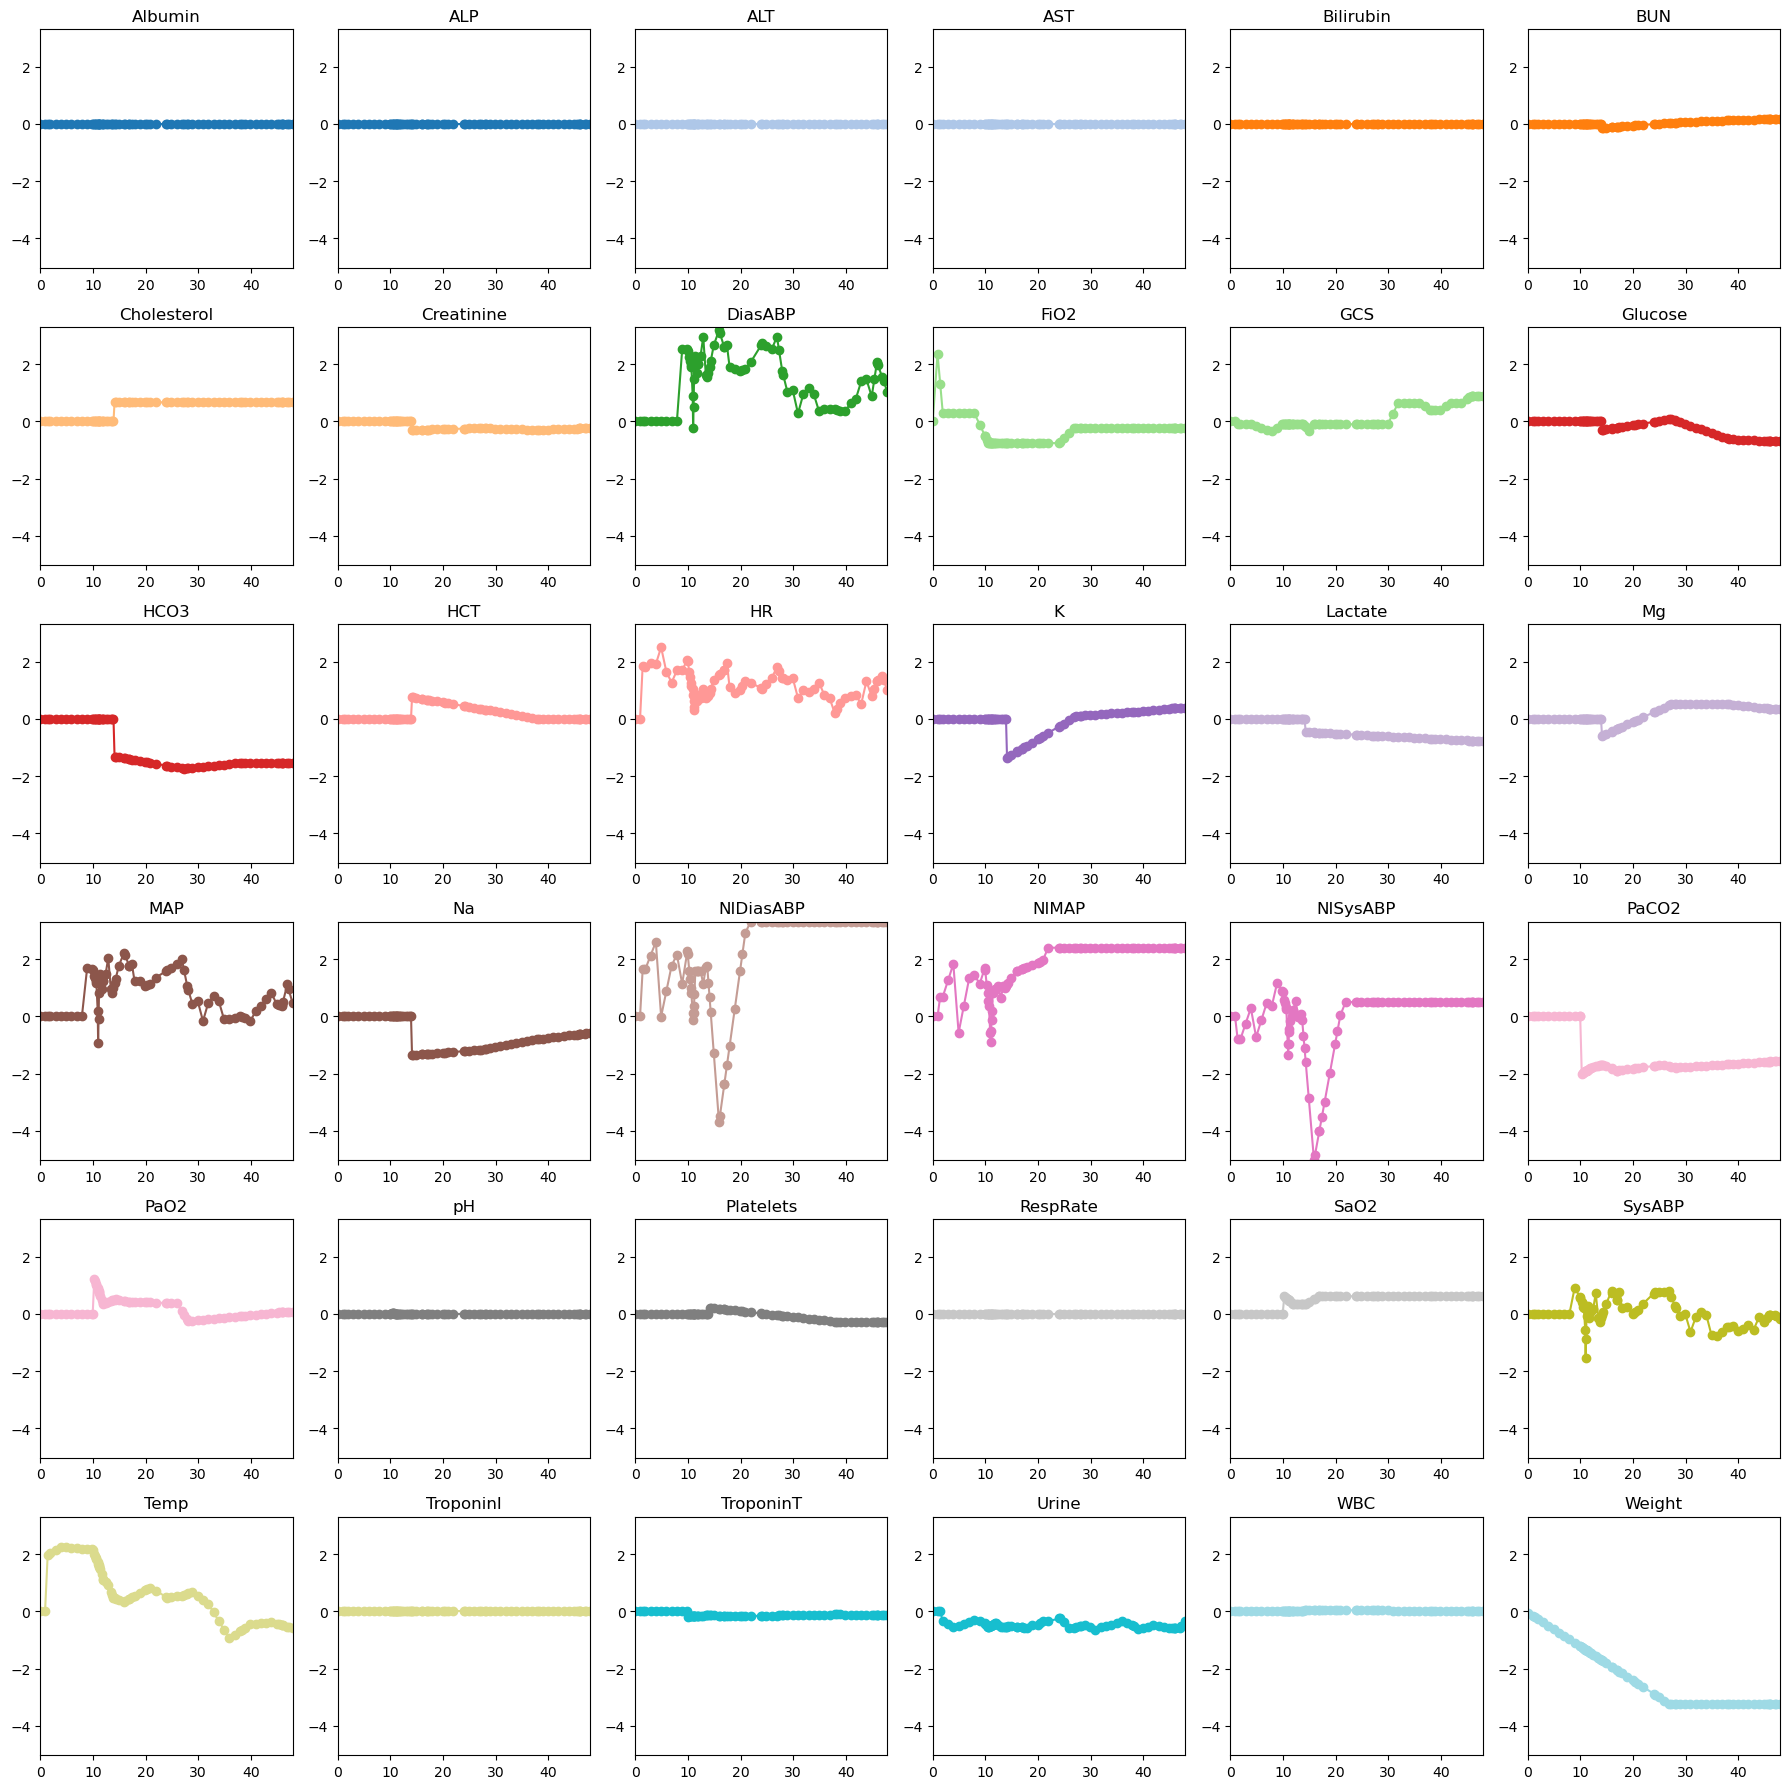

In [123]:
# ❗️prepare all imputed var arrays
x_train_zeroimpvaronly = zero_imputer(x_train_varonly)
plot_multivariate_ts(x_train_zeroimpvaronly[0], t_train[0], var_names_selected)
x_train_forwardimpvaronly = forward_imputer(x_train_varonly, t_train)
plot_multivariate_ts(x_train_forwardimpvaronly[0], t_train[0], var_names_selected)
x_train_linearimpvaronly = linear_imputer(x_train_varonly, t_train)
plot_multivariate_ts(x_train_linearimpvaronly[0], t_train[0], var_names_selected)

x_valid_zeroimpvaronly = zero_imputer(x_valid_varonly)
x_valid_forwardimpvaronly = forward_imputer(x_valid_varonly, t_valid)
x_valid_linearimpvaronly = linear_imputer(x_valid_varonly, t_valid)

# imputed full input
x_train_zeroimp = np.concatenate((x_train_zeroimpvaronly, x_train_maskonly, x_train_intervalonly), axis=-1)
x_train_forwardimp = np.concatenate((x_train_forwardimpvaronly, x_train_maskonly, x_train_intervalonly), axis=-1)
x_train_linearimp = np.concatenate((x_train_linearimpvaronly, x_train_maskonly, x_train_intervalonly), axis=-1)

x_valid_zeroimp = np.concatenate((x_valid_zeroimpvaronly, x_valid_maskonly, x_valid_intervalonly), axis=-1)
x_valid_forwardimp = np.concatenate((x_valid_forwardimpvaronly, x_valid_maskonly, x_valid_intervalonly), axis=-1)
x_valid_linearimp = np.concatenate((x_valid_linearimpvaronly, x_valid_maskonly, x_valid_intervalonly), axis=-1)

XGBoost classifier on imputed variables only (3 different imputers).

In [15]:
# impute and test again on variables only

x_train_zeroimpvaronly_flat = x_train_zeroimpvaronly.reshape(x_train_zeroimpvaronly.shape[0], -1)
print(x_train_zeroimpvaronly_flat.shape)
print(np.sum(np.isnan(x_train_varonly)), np.sum(np.isnan(x_train_zeroimpvaronly)))
print("first episode after zero imputation:")

x_valid_zeroimpvaronly_flat = x_valid_zeroimpvaronly.reshape(x_valid_zeroimpvaronly.shape[0], -1)

auroc = quick_fit_and_test_xgb_classifier(x_train_zeroimpvaronly_flat, y_train, x_valid_zeroimpvaronly_flat, y_valid)
print(f"XGBoost classifier on imputed variables (imputer=zero) alone, AUROC: {auroc:.4f}")


x_train_forwardimpvaronly_flat = x_train_forwardimpvaronly.reshape(x_train_forwardimpvaronly.shape[0], -1)
print(x_train_forwardimpvaronly_flat.shape)
print(np.sum(np.isnan(x_train_varonly)), np.sum(np.isnan(x_train_forwardimpvaronly)))
print("first episode after forward imputation:")

x_valid_forwardimpvaronly_flat = x_valid_forwardimpvaronly.reshape(x_valid_forwardimpvaronly.shape[0], -1)

auroc = quick_fit_and_test_xgb_classifier(x_train_forwardimpvaronly_flat, y_train, x_valid_forwardimpvaronly_flat, y_valid)
print(f"XGBoost classifier on imputed variables (imputer=forward) alone, AUROC: {auroc:.4f}")


x_train_linearimpvaronly_flat = x_train_linearimpvaronly.reshape(x_train_linearimpvaronly.shape[0], -1)
print(x_train_linearimpvaronly_flat.shape)
print(np.sum(np.isnan(x_train_varonly)), np.sum(np.isnan(x_train_linearimpvaronly)))
print("first episode after linear imputation:")

x_valid_linearimpvaronly_flat = x_valid_linearimpvaronly.reshape(x_valid_linearimpvaronly.shape[0], -1)

auroc = quick_fit_and_test_xgb_classifier(x_train_linearimpvaronly_flat, y_train, x_valid_linearimpvaronly_flat, y_valid)
print(f"XGBoost classifier on imputed variables (imputer=zero) alone, AUROC: {auroc:.4f}")


(9590, 7740)
70136757 0
first episode after zero imputation:
XGBoost classifier on imputed variables (imputer=zero) alone, AUROC: 0.8092
(9590, 7740)
70136757 0
first episode after forward imputation:
XGBoost classifier on imputed variables (imputer=forward) alone, AUROC: 0.8635
(9590, 7740)
70136757 0
first episode after linear imputation:
XGBoost classifier on imputed variables (imputer=zero) alone, AUROC: 0.8598


XGBoost classifier on full input: imputed variables - mask - interval (3 different imputers).

In [ ]:
# test full input with imputed variables

x_train_zeroimp_flat = x_train_zeroimp.reshape(x_train_zeroimp.shape[0], -1)
print(x_train_zeroimp_flat.shape)
print(np.sum(np.isnan(x_train_flat)), np.sum(np.isnan(x_train_zeroimp_flat)))

x_valid_zeroimp_flat = x_valid_zeroimp.reshape(x_valid_zeroimp.shape[0], -1)

auroc = quick_fit_and_test_xgb_classifier(x_train_zeroimp_flat, y_train, x_valid_zeroimp_flat, y_valid)
print(f"XGBoost classifier on full input with imputed variables (imputer=zero), AUROC: {auroc:.4f}")


x_train_forwardimp_flat = x_train_forwardimp.reshape(x_train_forwardimp.shape[0], -1)
print(x_train_forwardimp_flat.shape)
print(np.sum(np.isnan(x_train_flat)), np.sum(np.isnan(x_train_forwardimp_flat)))

x_valid_forwardimp_flat = x_valid_forwardimp.reshape(x_valid_forwardimp.shape[0], -1)

auroc = quick_fit_and_test_xgb_classifier(x_train_forwardimp_flat, y_train, x_valid_forwardimp_flat, y_valid)
print(f"XGBoost classifier on full input with imputed variables (imputer=forward), AUROC: {auroc:.4f}")


x_train_linearimp_flat = x_train_linearimp.reshape(x_train_linearimp.shape[0], -1)
print(x_train_linearimp_flat.shape)
print(np.sum(np.isnan(x_train_flat)), np.sum(np.isnan(x_train_linearimp_flat)))

x_valid_linearimp_flat = x_valid_linearimp.reshape(x_valid_linearimp.shape[0], -1)

auroc = quick_fit_and_test_xgb_classifier(x_train_linearimp_flat, y_train, x_valid_linearimp_flat, y_valid)
print(f"XGBoost classifier on full input with imputed variables (imputer=linear), AUROC: {auroc:.4f}")


XGBoost classifier on partial input: imputed variables - mask (3 different imputers).

In [ ]:
# test imputed variables + mask

x_train_zeroimpvarmask = np.concatenate((x_train_zeroimpvaronly, x_train_maskonly), axis=-1)
x_train_zeroimpvarmask_flat = x_train_zeroimpvarmask.reshape(x_train_zeroimpvarmask.shape[0], -1)
print(x_train_zeroimpvarmask_flat.shape)
print(np.sum(np.isnan(x_train_varmask_flat)), np.sum(np.isnan(x_train_zeroimpvarmask_flat)))

x_valid_zeroimpvarmask = np.concatenate((x_valid_zeroimpvaronly, x_valid_maskonly), axis=-1)
x_valid_zeroimpvarmask_flat = x_valid_zeroimpvarmask.reshape(x_valid_zeroimpvarmask.shape[0], -1)

auroc = quick_fit_and_test_xgb_classifier(x_train_zeroimpvarmask_flat, y_train, x_valid_zeroimpvarmask_flat, y_valid)
print(f"XGBoost classifier on full input with imputed variables (imputer=zero) + mask, AUROC: {auroc:.4f}")


x_train_forwardimpvarmask = np.concatenate((x_train_forwardimpvaronly, x_train_maskonly), axis=-1)
x_train_forwardimpvarmask_flat = x_train_forwardimpvarmask.reshape(x_train_forwardimpvarmask.shape[0], -1)
print(x_train_forwardimpvarmask_flat.shape)
print(np.sum(np.isnan(x_train_varmask_flat)), np.sum(np.isnan(x_train_forwardimpvarmask_flat)))

x_valid_forwardimpvarmask = np.concatenate((x_valid_forwardimpvaronly, x_valid_maskonly), axis=-1)
x_valid_forwardimpvarmask_flat = x_valid_forwardimpvarmask.reshape(x_valid_forwardimpvarmask.shape[0], -1)

auroc = quick_fit_and_test_xgb_classifier(x_train_forwardimpvarmask_flat, y_train, x_valid_forwardimpvarmask_flat, y_valid)
print(f"XGBoost classifier on full input with imputed variables (imputer=forward) + mask, AUROC: {auroc:.4f}")


x_train_linearimpvarmask = np.concatenate((x_train_linearimpvaronly, x_train_maskonly), axis=-1)
x_train_linearimpvarmask_flat = x_train_linearimpvarmask.reshape(x_train_linearimpvarmask.shape[0], -1)
print(x_train_linearimpvarmask_flat.shape)
print(np.sum(np.isnan(x_train_varmask_flat)), np.sum(np.isnan(x_train_linearimpvarmask_flat)))

x_valid_linearimpvarmask = np.concatenate((x_valid_linearimpvaronly, x_valid_maskonly), axis=-1)
x_valid_linearimpvarmask_flat = x_valid_linearimpvarmask.reshape(x_valid_linearimpvarmask.shape[0], -1)

auroc = quick_fit_and_test_xgb_classifier(x_train_linearimpvarmask_flat, y_train, x_valid_linearimpvarmask_flat, y_valid)
print(f"XGBoost classifier on full input with imputed variables (imputer=linear) + mask, AUROC: {auroc:.4f}")


XGBoost classifier on partial input: imputed variables - interval (3 different imputers).

In [ ]:
# test imputed variables + interval

x_train_zeroimpvarinterval = np.concatenate((x_train_zeroimpvaronly, x_train_intervalonly), axis=-1)
x_train_zeroimpvarinterval_flat = x_train_zeroimpvarinterval.reshape(x_train_zeroimpvarinterval.shape[0], -1)
print(x_train_zeroimpvarinterval_flat.shape)
print(np.sum(np.isnan(x_train_varinterval_flat)), np.sum(np.isnan(x_train_zeroimpvarinterval_flat)))

x_valid_zeroimpvarinterval = np.concatenate((x_valid_zeroimpvaronly, x_valid_intervalonly), axis=-1)
x_valid_zeroimpvarinterval_flat = x_valid_zeroimpvarinterval.reshape(x_valid_zeroimpvarinterval.shape[0], -1)

auroc = quick_fit_and_test_xgb_classifier(x_train_zeroimpvarinterval_flat, y_train, x_valid_zeroimpvarinterval_flat, y_valid)
print(f"XGBoost classifier on full input with imputed variables (imputer=zero) + interval, AUROC: {auroc:.4f}")


x_train_forwardimpvarinterval = np.concatenate((x_train_forwardimpvaronly, x_train_intervalonly), axis=-1)
x_train_forwardimpvarinterval_flat = x_train_forwardimpvarinterval.reshape(x_train_forwardimpvarinterval.shape[0], -1)
print(x_train_forwardimpvarinterval_flat.shape)
print(np.sum(np.isnan(x_train_varinterval_flat)), np.sum(np.isnan(x_train_forwardimpvarinterval_flat)))

x_valid_forwardimpvarinterval = np.concatenate((x_valid_forwardimpvaronly, x_valid_intervalonly), axis=-1)
x_valid_forwardimpvarinterval_flat = x_valid_forwardimpvarinterval.reshape(x_valid_forwardimpvarinterval.shape[0], -1)

auroc = quick_fit_and_test_xgb_classifier(x_train_forwardimpvarinterval_flat, y_train, x_valid_forwardimpvarinterval_flat, y_valid)
print(f"XGBoost classifier on full input with imputed variables (imputer=forward) + interval, AUROC: {auroc:.4f}")


x_train_linearimpvarinterval = np.concatenate((x_train_linearimpvaronly, x_train_intervalonly), axis=-1)
x_train_linearimpvarinterval_flat = x_train_linearimpvarinterval.reshape(x_train_linearimpvarinterval.shape[0], -1)
print(x_train_linearimpvarinterval_flat.shape)
print(np.sum(np.isnan(x_train_varinterval_flat)), np.sum(np.isnan(x_train_linearimpvarinterval_flat)))

x_valid_linearimpvarinterval = np.concatenate((x_valid_linearimpvaronly, x_valid_intervalonly), axis=-1)
x_valid_linearimpvarinterval_flat = x_valid_linearimpvarinterval.reshape(x_valid_linearimpvarinterval.shape[0], -1)

auroc = quick_fit_and_test_xgb_classifier(x_train_linearimpvarinterval_flat, y_train, x_valid_linearimpvarinterval_flat, y_valid)
print(f"XGBoost classifier on full input with imputed variables (imputer=linear) + interval, AUROC: {auroc:.4f}")


## 3 Green learning

In [96]:
# define and fit the saab modules
from src.torch_ssl.torch_ssl import torchSaab, sslModel

x_train_forwardimpvaronly_expanded = np.expand_dims(x_train_forwardimpvaronly, axis=1)
print(x_train_forwardimpvaronly_expanded.shape)

# layers = [
#     torchSaab(kernel_size=(6,1), stride=(1,1), channelwise=False),
#     torchSaab(kernel_size=(7,1), stride=(7,1), channelwise=True),
#     torchSaab(kernel_size=(6,1), stride=(6,1), channelwise=True),
#     torchSaab(kernel_size=(5,36), stride=(5,36), channelwise=True),
# ]
layers = [
    torchSaab(kernel_size=(215,36), stride=(215,36), channelwise=False),
]
# difference between c/w saab and saab: https://arxiv.org/pdf/2002.03141 (fig.2)

ssl_model = sslModel(layers)

# fit the model

ssl_model.fit(x_train_forwardimpvaronly_expanded);

(9590, 1, 215, 36)
learned parameters for layer 0, output size was torch.Size([9590, 7740, 1, 1])


In [98]:
# get spectral features through saab transforms

x_train_forwardimpvaronly_spectral = ssl_model(x_train_forwardimpvaronly_expanded)

x_train_forwardimpvaronly_spectral_flat = x_train_forwardimpvaronly_spectral.reshape(x_train_forwardimpvaronly_spectral.shape[0], -1) # flatten
# ensemble
# subspace_x_tr = np.concatenate([x_tr.reshape(x_tr.shape[0], -1), subspace_x_tr,], axis=1)
print(f'features size = {x_train_forwardimpvaronly_spectral_flat.shape}')

features size = (9590, 7740)


(9590, 7740) (9590,)


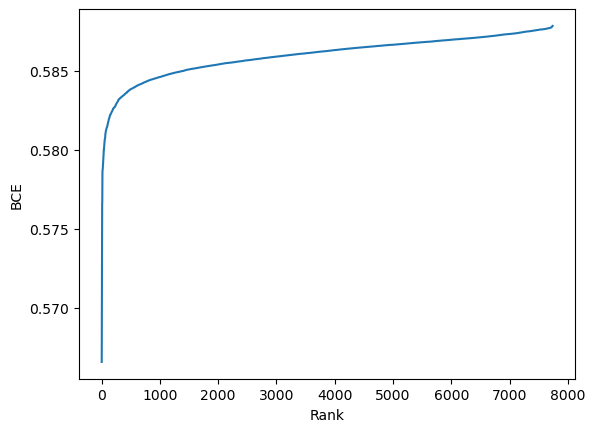

In [99]:
# define and fit the feature selection model on spectral features

from src.feature_test.utils import FeatureTest
from matplotlib import pyplot as plt

## Synthetic binary classification datasets: 1000 samples, 100 features
# X = np.random.randn(1000, 100)
# y = np.zeros(1000)
# pos_idx = np.arange(1000)
# np.random.shuffle(pos_idx)
# y[pos_idx[:500]] = 1

### train DFT
dft_model_spectral = FeatureTest(loss='bce')
print(x_train_forwardimpvaronly_spectral_flat.shape, y_train.shape)
dft_model_spectral.fit(x_train_forwardimpvaronly_spectral_flat, y_train, n_bins=32)

plt.figure()
plt.plot(np.arange(x_train_forwardimpvaronly_spectral_flat.shape[-1]), np.array(list(dft_model_spectral.dim_loss.values())))
plt.xlabel('Rank')
plt.ylabel('BCE')
plt.show()

In [115]:
# select top rank significant spectral features
N_SELECTED_SPECTRAL = 100

x_train_forwardimpvaronly_spectral_topranks = dft_model_spectral.transform(x_train_forwardimpvaronly_spectral_flat, n_selected=N_SELECTED_SPECTRAL)
print(x_train_forwardimpvaronly_spectral_topranks.shape)

(9590, 100)


(9590, 7740)
(9590, 7740) (9590,)


/Users/d9sus4/Documents/research projects/GL-TS/src/feature_test/utils.py:55: RuntimeWarning: Mean of empty slice.
  rp = y_r.mean()
/Users/d9sus4/miniconda3/envs/playground/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


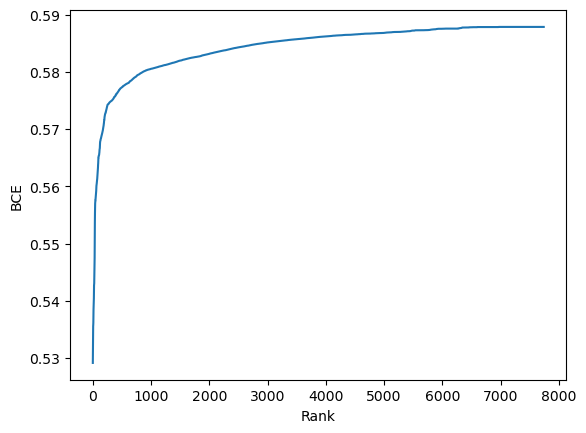

In [101]:
# fit the feature selection model on original variables
x_train_forwardimpvaronly_flat = x_train_forwardimpvaronly.reshape(x_train_forwardimpvaronly.shape[0], -1)
print(x_train_forwardimpvaronly_flat.shape)

dft_model_original = FeatureTest(loss='bce')
print(x_train_forwardimpvaronly_flat.shape, y_train.shape)
dft_model_original.fit(x_train_forwardimpvaronly_flat, y_train, n_bins=32)

plt.figure()
plt.plot(np.arange(x_train_forwardimpvaronly_flat.shape[-1]), np.array(list(dft_model_original.dim_loss.values())))
plt.xlabel('Rank')
plt.ylabel('BCE')
plt.show()

In [120]:
# select top rank significant original variables
N_SELECTED_ORIGINAL = 1024

x_train_forwardimpvaronly_original_topranks = dft_model_original.transform(x_train_forwardimpvaronly_flat, n_selected=N_SELECTED_ORIGINAL)
print(x_train_forwardimpvaronly_original_topranks.shape)

(9590, 1024)


In [138]:
# create ensemble training feature: var_original+feat_spectral+d

# x_train_ensemble = np.concatenate([x_train_forwardimpvaronly_spectral_topranks, x_train_forwardimpvaronly_original_topranks,], axis=1)
# x_train_ensemble = np.concatenate([x_train_forwardimpvaronly_spectral_topranks, x_train_forwardimpvaronly_original_topranks, x_train_intervalonly.reshape(x_train_intervalonly.shape[0], -1)], axis=1)
# x_train_ensemble = np.concatenate([x_train_forwardimpvaronly_spectral_topranks, x_train_forwardimpvaronly.reshape(x_train_forwardimpvaronly.shape[0], -1), x_train_intervalonly.reshape(x_train_intervalonly.shape[0], -1)], axis=1)
x_train_ensemble = np.concatenate([x_train_forwardimpvaronly_spectral_flat, x_train_forwardimpvaronly.reshape(x_train_forwardimpvaronly.shape[0], -1), x_train_intervalonly.reshape(x_train_intervalonly.shape[0], -1)], axis=1)
print(x_train_ensemble.shape)

(9590, 23220)


In [140]:
# select top rank validation features (spectral + original temporal)
x_valid_forwardimpvaronly_expanded = np.expand_dims(x_valid_forwardimpvaronly, axis=1)
x_valid_forwardimpvaronly_spectral = ssl_model(x_valid_forwardimpvaronly_expanded)
x_valid_forwardimpvaronly_spectral_flat = x_valid_forwardimpvaronly_spectral.reshape(x_valid_forwardimpvaronly_spectral.shape[0], -1) # flatten

x_valid_forwardimpvaronly_spectral_topranks = dft_model_spectral.transform(x_valid_forwardimpvaronly_spectral_flat, n_selected=N_SELECTED_SPECTRAL)
x_valid_forwardimpvaronly_original_topranks = dft_model_original.transform(x_valid_forwardimpvaronly_flat, n_selected=N_SELECTED_ORIGINAL)

NameError: name 'dft_model_spectral' is not defined

In [141]:
# create ensemble validation feature

# x_valid_ensemble = np.concatenate([x_valid_forwardimpvaronly_spectral_topranks, x_valid_forwardimpvaronly_original_topranks,], axis=1)
# x_valid_ensemble = np.concatenate([x_valid_forwardimpvaronly_spectral_topranks, x_valid_forwardimpvaronly_original_topranks, x_valid_intervalonly.reshape(x_valid_intervalonly.shape[0], -1)], axis=1)
# x_valid_ensemble = np.concatenate([x_valid_forwardimpvaronly_spectral_topranks, x_valid_forwardimpvaronly.reshape(x_valid_forwardimpvaronly.shape[0], -1), x_valid_intervalonly.reshape(x_valid_intervalonly.shape[0], -1)], axis=1)
x_valid_ensemble = np.concatenate([x_valid_forwardimpvaronly_spectral_flat, x_valid_forwardimpvaronly.reshape(x_valid_forwardimpvaronly.shape[0], -1), x_valid_intervalonly.reshape(x_valid_intervalonly.shape[0], -1)], axis=1)
print(x_valid_ensemble.shape)

(1199, 23220)


In [142]:
# test
auroc = quick_fit_and_test_xgb_classifier(x_train_ensemble, y_train, x_valid_ensemble, y_valid)
auroc

0.8526524437953158

(9590, 23220) (9590,)


/Users/d9sus4/Documents/research projects/GL-TS/src/feature_test/utils.py:55: RuntimeWarning: Mean of empty slice.
  rp = y_r.mean()
/Users/d9sus4/miniconda3/envs/playground/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/d9sus4/Documents/research projects/GL-TS/src/feature_test/utils.py:50: RuntimeWarning: Mean of empty slice.
  lp = y_l.mean()
/Users/d9sus4/Documents/research projects/GL-TS/src/feature_test/utils.py:60: RuntimeWarning: invalid value encountered in scalar divide
  return (lh + rh) / (n1 + n2)


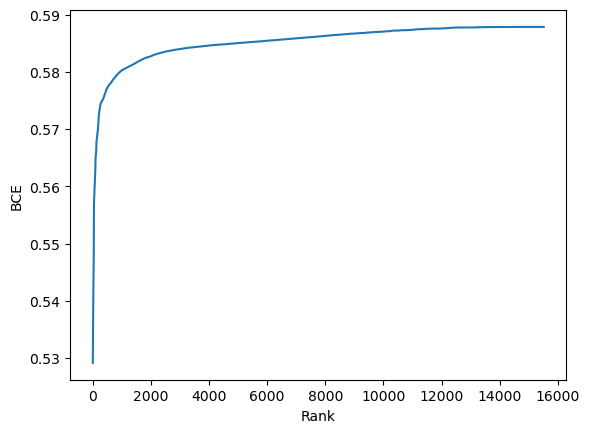

In [124]:
# see if feature test really works

x_train_forwardimp_flat = x_train_forwardimp.reshape(x_train_forwardimp.shape[0], -1)

dft_model_full = FeatureTest(loss='bce')
print(x_train_forwardimp_flat.shape, y_train.shape)
dft_model_full.fit(x_train_forwardimp_flat, y_train, n_bins=32)

plt.figure()
plt.plot(np.arange(x_train_forwardimp_flat.shape[-1]), np.array(list(dft_model_full.dim_loss.values())))
plt.xlabel('Rank')
plt.ylabel('BCE')
plt.show()

In [137]:
# continued
N_SELECTED_FULL = 14000

x_train_forwardimp_topranks = dft_model_full.transform(x_train_forwardimp_flat, n_selected=N_SELECTED_FULL)
print(x_train_forwardimp_topranks.shape)

x_valid_forwardimp_flat = x_valid_forwardimp.reshape(x_valid_forwardimp.shape[0], -1)
x_valid_forwardimp_topranks = dft_model_full.transform(x_valid_forwardimp_flat, n_selected=N_SELECTED_FULL)
print(x_valid_forwardimp_topranks.shape)

auroc = quick_fit_and_test_xgb_classifier(x_train_forwardimp_topranks, y_train, x_valid_forwardimp_topranks, y_valid)
auroc

(9590, 14000)
(1199, 14000)


0.8645714881852797

## 4 New path

In [146]:
for name in var_names_selected:
    print(name+'_mask')

Albumin_mask
ALP_mask
ALT_mask
AST_mask
Bilirubin_mask
BUN_mask
Cholesterol_mask
Creatinine_mask
DiasABP_mask
FiO2_mask
GCS_mask
Glucose_mask
HCO3_mask
HCT_mask
HR_mask
K_mask
Lactate_mask
Mg_mask
MAP_mask
Na_mask
NIDiasABP_mask
NIMAP_mask
NISysABP_mask
PaCO2_mask
PaO2_mask
pH_mask
Platelets_mask
RespRate_mask
SaO2_mask
SysABP_mask
Temp_mask
TroponinI_mask
TroponinT_mask
Urine_mask
WBC_mask
Weight_mask


In [172]:
import numpy as np
import matplotlib.pyplot as plt

# Reshape the input to 2D
x_train_flat = x_train_normalized.reshape((x_train_normalized.shape[0], -1))

# Fit the XGBoost model
model = xgb.XGBClassifier()
model.fit(x_train_flat, y_train)

# Get feature importance by 'gain'
booster = model.get_booster()
importance = booster.get_score(importance_type='gain')

# Convert the importance dictionary into a numpy array where we know the flattened feature length is L=215 * C=108
print(x_train_flat.shape[1])
importance_values = np.zeros(x_train_flat.shape[1])
for feature, score in importance.items():
    importance_values[int(feature[1:])] = score

# Reshape it back to (L, C) to reflect temporal variations per feature
importance_reshaped = importance_values.reshape(x_train_normalized.shape[1:])

# Aggregate the importance across the 215 time steps for each of the 108 features
importance_per_feature = np.sum(importance_reshaped, axis=0)


23220


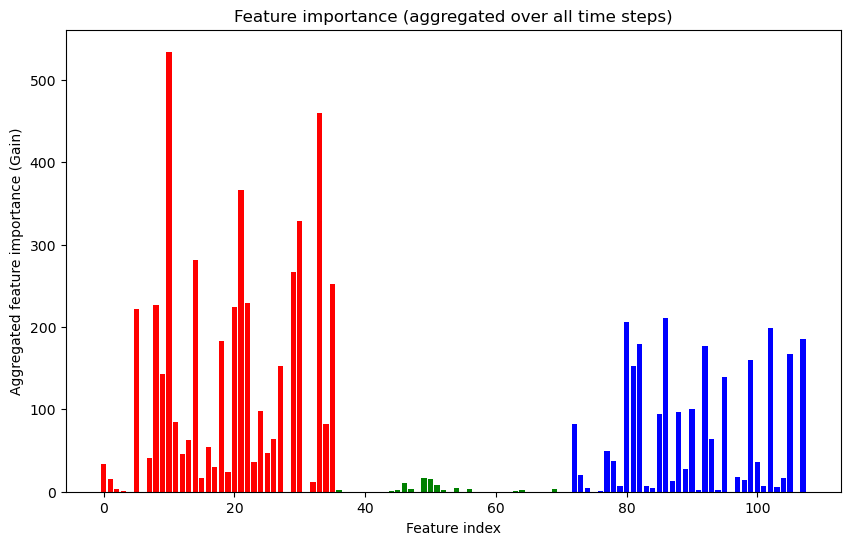

In [173]:
# plot the importance factor (gain) in original order
# Define the number of features
num_features = x_train_normalized.shape[2]
third = num_features // 3  # Compute one third of the number of features

# Create colors for the first, middle, and last third
colors = ['red'] * third + ['green'] * third + ['blue'] * (num_features - 2 * third)

# Plot the feature importance for the 108 features with distinct colors for each third
plt.figure(figsize=(10, 6))
plt.bar(range(num_features), importance_per_feature, color=colors)
plt.xlabel("Feature index")
plt.ylabel("Aggregated feature importance (Gain)")
plt.title("Feature importance (aggregated over all time steps)")
plt.show()

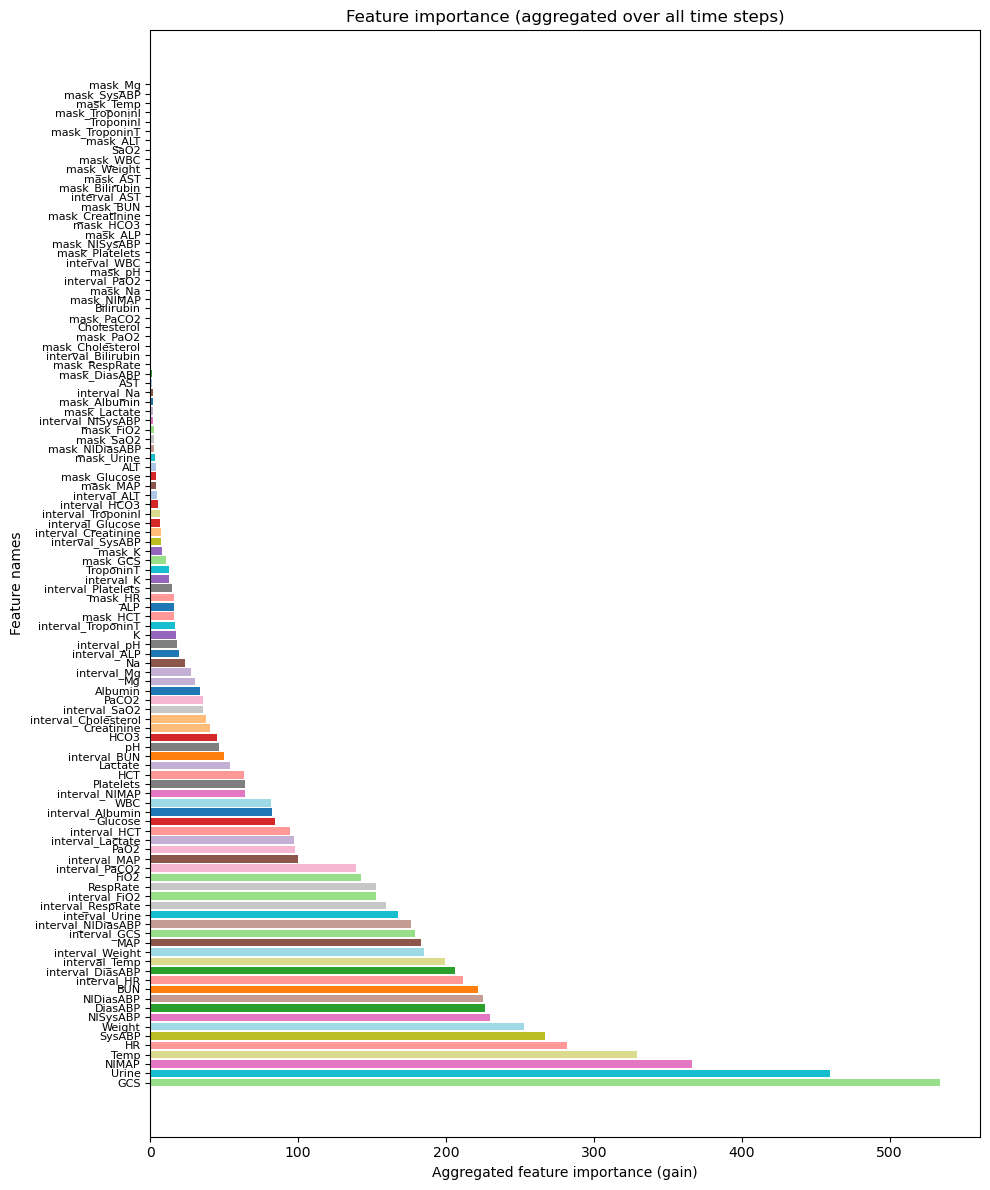

In [174]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Create the complete names for the 108 features
feature_names = []
for name in var_names_selected:
    feature_names.append(name)                  # First 36 features
for name in var_names_selected:
    feature_names.append('mask_' + name)        # Second 36 features (masks)
for name in var_names_selected:
    feature_names.append('interval_' + name)    # Last 36 features (intervals)

# Generate distinct colors for the bars
cmap = plt.colormaps.get_cmap('tab20')  # Use 'tab20' colormap
colors = [cmap(i) for i in np.linspace(0, 1, len(var_names_selected))]  # Get distinct colors for 36 features

# Sort the importance_per_feature and corresponding feature names in descending order of importance
sorted_indices = np.argsort(importance_per_feature)[::-1]
sorted_importance = importance_per_feature[sorted_indices]
sorted_feature_names = np.array(feature_names)[sorted_indices]

# Create a mapping of the features to colors based on feature groups (true, mask, interval)
bar_colors = []
label_colors = []  # To store y-tick label colors for true, mask, interval

# Assign bar color based on the feature name groupings
for feature_name in sorted_feature_names:
    if 'mask_' in feature_name:
        base_feature_idx = var_names_selected.index(feature_name.replace('mask_', ''))
        bar_colors.append(colors[base_feature_idx])  # Use the same color as the corresponding true feature
        label_colors.append('green')  # Set y-axis label color for masks (choose your color)
    elif 'interval_' in feature_name:
        base_feature_idx = var_names_selected.index(feature_name.replace('interval_', ''))
        bar_colors.append(colors[base_feature_idx])  # Same color as the corresponding true feature
        label_colors.append('blue')  # Set y-axis label color for intervals
    else:
        base_feature_idx = var_names_selected.index(feature_name)
        bar_colors.append(colors[base_feature_idx])  # Assign color based on feature group
        label_colors.append('black')  # Set y-axis label color for true features

# Plot the sorted feature importance with inverted axes and distinct colors
plt.figure(figsize=(10, 12))

# Plot each bar with the appropriate color
for i in range(len(sorted_importance)):
    plt.barh(i, sorted_importance[i], color=bar_colors[i])

# Modify the y-axis ticks to display different colors for true features, masks, and intervals
ax = plt.gca()
y_labels = ax.get_yticks()
for i, label in enumerate(ax.get_yticklabels()):
    label.set_color(label_colors[i])  # Set the color for each label based on true, mask, or interval

# Customize the rest of the plot
plt.yticks(range(len(sorted_feature_names)), sorted_feature_names, fontsize=8)
plt.xlabel("Aggregated feature importance (gain)")
plt.ylabel("Feature names")
plt.title("Feature importance (aggregated over all time steps)")
plt.tight_layout()

plt.show()


In [190]:
# filter out 10 most significant features
most_important_var_names = sorted_feature_names[:10]
print(most_important_var_names)
importance_mask = []
for var_name in var_names_selected:
    importance_mask.append(var_name in most_important_var_names)
importance_mask = np.array(importance_mask, dtype=bool)
print(importance_mask)

var_names_important = np.array(var_names_selected)[importance_mask]

x_train_important = select_features(x=x_train_normalized, feature_keep_mask=importance_mask, copy=True)
x_train_important_flat = x_train_important.reshape(x_train_important.shape[0], -1)
print(x_train_important.shape)
x_valid_important = select_features(x=x_valid_normalized, feature_keep_mask=importance_mask, copy=True)
x_valid_important_flat = x_valid_important.reshape(x_valid_important.shape[0], -1)
x_test_important = select_features(x=x_test_normalized, feature_keep_mask=importance_mask, copy=True)

auroc = quick_fit_and_test_xgb_classifier(x_train_important_flat, y_train, x_valid_important_flat, y_valid)
auroc

['GCS' 'Urine' 'NIMAP' 'Temp' 'HR' 'SysABP' 'Weight' 'NISysABP' 'DiasABP'
 'NIDiasABP']
[False False False False False False False False  True False  True False
 False False  True False False False False False  True  True  True False
 False False False False False  True  True False False  True False  True]
(9590, 215, 30)


0.811217463877732

In [192]:
# test 10 most significant features x-d discriminant ability

n_features_important = len(most_important_var_names)
x_train_important_varonly = x_train_important[:,:,:n_features_important]
x_train_important_intervalonly = x_train_important[:,:,-n_features_important:]
x_train_important_varinterval = np.concatenate([x_train_important_varonly, x_train_important_intervalonly], axis=-1)
x_train_important_varinterval_flat = x_train_important_varinterval.reshape(x_train_important_varinterval.shape[0], -1)
print(x_train_important_varinterval.shape)
x_valid_important_varonly = x_valid_important[:,:,:n_features_important]
x_valid_important_intervalonly = x_valid_important[:,:,-n_features_important:]
x_valid_important_varinterval = np.concatenate([x_valid_important_varonly, x_valid_important_intervalonly], axis=-1)
x_valid_important_varinterval_flat = x_valid_important_varinterval.reshape(x_valid_important_varinterval.shape[0], -1)
auroc = quick_fit_and_test_xgb_classifier(x_train_important_varinterval_flat, y_train, x_valid_important_varinterval_flat, y_valid)
auroc

(9590, 215, 20)


0.8105237076834803

## 5 Interpretable Analysis